# Import libraries

In [1]:
# General libraries
import numpy as np
import h5py

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
import ximinf.selection_effects as se
import ximinf.generate_sim as gsim

# Plot libraries
import matplotlib.pyplot as plt

# Generation of SN Ia samples in parallel

In [ ]:
# -------- User parameters --------

N = 5000 # Number of samples 100_000
M = 300 # Number of SNe per sample #3_000

# ---------------------------------

ranges = {
    'alpha': (-2,2), #(-0.5, -0.0),
    'beta': (1,5), #(2.0, 4.0),
    'mabs': (-21, -17), #(-19.5, -19.0),
    'gamma': (-2,2) #(0.0, 0.3)
}

columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'prompt', 'localcolor', 'localcolor_err', 'z']

params_dict = gsim.scan_params(ranges, N)

print("Running parallel simulations...")

# with parallel_backend("threading"):
results = Parallel(n_jobs=6)(
    delayed(gsim.simulate_one)(
        {k: v[i] for k, v in params_dict.items()},  # ensure all floats
        z_max=0.2,
        M=M,
        cols=columns,
        N=N,
        i=i
    )
    for i in range(N)
)

print("... done")

Running parallel simulations...
... doneon 5000/5000


# Apply selection effects

In [4]:
# # Applying selection effect
# print('Applying selection effect...')
# m_lim = 19.5
# results = se.malmquist_bias_batch(results, m_lim, M, columns)
# print('...done')

# Plot the first sample

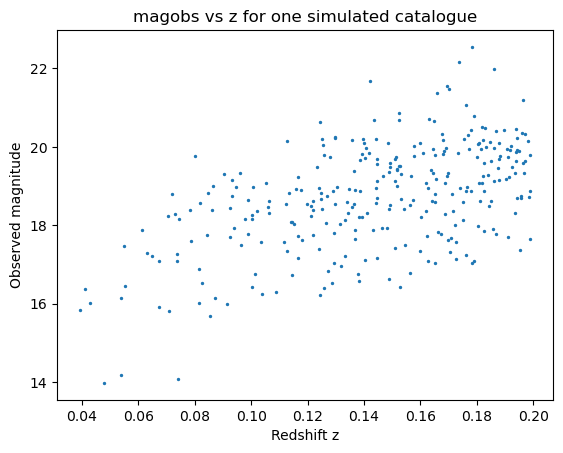

Number of SNe after selection: 300


In [5]:
# Take one simulation
example = results[5]

# Convert columns to NumPy arrays for easier indexing
magobs = np.array(example['magobs'])
z      = np.array(example['z'])

# Apply selection (magobs > 0)
mask = magobs > 0
magobs_cut = magobs[mask]
z_cut = z[mask]

# Plot
plt.figure()
plt.scatter(z_cut, magobs_cut, s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

# Number of SNe after selection
print('Number of SNe after selection:', len(magobs_cut))


# Save data to disk

## Build a dict of big arrays

In [6]:
dict_arrays = {col: np.zeros((N, M), dtype=np.float32) for col in columns}

for i, sim_data in enumerate(results):  # sim_data is just the dict returned by simulate_one
    for col, arr in sim_data.items():   # arr is a list of length M
        dict_arrays[col][i, :] = arr   # fill row i

## Estimate size

In [7]:
# Data size in bytes
total_bytes = sum(arr.nbytes for arr in dict_arrays.values())

# Parameters size in bytes
total_bytes += sum(arr.nbytes for arr in params_dict.values())

# Convert to MB
size_MB = total_bytes / (1024**2)
print(f"Estimated size on disk: {size_MB:.2f} MB")

Estimated size on disk: 57.30 MB


## Save

In [8]:
save_path = "../data/SIM/simulations.h5"

with h5py.File(save_path, "w") as f:
    # Save parameters
    for key, arr in params_dict.items():  # each arr has shape (N,)
        f.create_dataset(f"params/{key}", data=arr, dtype=np.float32)
    
    # Save data columns
    for col, arr in dict_arrays.items():  # each arr has shape (N, M)
        f.create_dataset(f"data/{col}", data=arr, dtype=np.float32)
